### Notebook that multiplies the data in a YOLOv8 object detection dataset via use of various transformations, without need for relabelling the bounding boxes.

Install the required dependencies in your environment. This can be done in the notebook as well:

In [1]:
!pip install imgaug


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import cv2
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

Specify the paths to the dataset

In [3]:
DIR = '../data/real_dataset'
SUBDIR = 'train'
NEW_DIR = f'{DIR}_augmented'

In [4]:
input_dir = f'{DIR}/{SUBDIR}/images'
label_dir = f'{DIR}/{SUBDIR}/labels'
output_img_dir = f'{NEW_DIR}/{SUBDIR}/images'
output_label_dir = f'{NEW_DIR}/{SUBDIR}/labels'

Specify the transformations used for augmentation:

In [5]:
seq = iaa.Sequential([
    iaa.Crop(percent=(0, 0.1)),  # Random crops
    iaa.Affine(scale=(0.5, 1.5)),  # Scaling
    iaa.Multiply((0.8, 1.2)),  # Change brightness
    iaa.LinearContrast((0.75, 1.5)),  # Change contrast
    iaa.Affine(rotate=(-15, 15))  # Rotation
])

In [6]:
os.makedirs(output_img_dir, exist_ok=True)
os.makedirs(output_label_dir, exist_ok=True)

In [7]:
def read_yolo_labels(label_path):
    with open(label_path, 'r') as file:
        lines = file.readlines()
        labels = []
        for line in lines:
            parts = line.strip().split()
            cls, cx, cy, w, h = map(float, parts)
            labels.append((cls, cx, cy, w, h))
        return labels


def save_yolo_labels(label_path, labels):
    with open(label_path, 'w') as file:
        for label in labels:
            file.write(' '.join(map(str, label)) + '\n')


def augment_image_and_labels(image, labels):
    h, w = image.shape[:2]
    bbs = BoundingBoxesOnImage([
        BoundingBox(
            x1=(cx - 0.5 * bw) * w,
            y1=(cy - 0.5 * bh) * h,
            x2=(cx + 0.5 * bw) * w,
            y2=(cy + 0.5 * bh) * h,
            label=int(cls)  # Ensure the label is set correctly
        ) for cls, cx, cy, bw, bh in labels
    ], shape=image.shape)

    # Augment image and bounding boxes
    image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)

    # Convert bounding boxes back to YOLO format
    labels_aug = []
    for bb in bbs_aug.bounding_boxes:
        cx = (bb.x1 + bb.x2) / 2 / w
        cy = (bb.y1 + bb.y2) / 2 / h
        bw = (bb.x2 - bb.x1) / w
        bh = (bb.y2 - bb.y1) / h
        labels_aug.append((bb.label, cx, cy, bw, bh))

    return image_aug, labels_aug

Process each image and its label:

In [8]:
for image_name in os.listdir(input_dir):
    if image_name.endswith('.jpg'):
        base_name = os.path.splitext(image_name)[0]
        img_path = os.path.join(input_dir, image_name)
        label_path = os.path.join(label_dir, base_name + '.txt')

        # Read image and labels
        image = cv2.imread(img_path)
        labels = read_yolo_labels(label_path)

        # Augment and save multiple versions
        for i in range(10):  # Number of augmentations per image
            image_aug, labels_aug = augment_image_and_labels(image, labels)
            aug_img_path = os.path.join(output_img_dir, f'{base_name}_aug_{i}.jpg')
            aug_label_path = os.path.join(output_label_dir, f'{base_name}_aug_{i}.txt')
            
            # Save augmented image and label
            cv2.imwrite(aug_img_path, image_aug)
            save_yolo_labels(aug_label_path, labels_aug)

### Visualize a random image with the new label:

In [9]:
import matplotlib.pyplot as plt
import random

In [10]:
def draw_bounding_boxes(image, labels):
    fig, ax = plt.subplots(1)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    h, w = image.shape[:2]

    for label in labels:
        cls, cx, cy, bw, bh = label
        x1 = int((cx - bw / 2) * w)
        y1 = int((cy - bh / 2) * h)
        x2 = int((cx + bw / 2) * w)
        y2 = int((cy + bh / 2) * h)
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

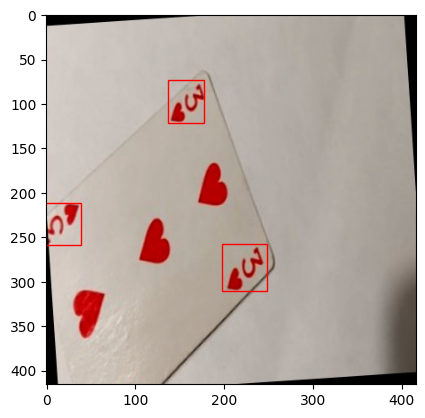

In [12]:
# Select a random augmented image and its labels
aug_images = [f for f in os.listdir(output_img_dir) if f.endswith('.jpg')]
random_image_name = random.choice(aug_images)
base_name = os.path.splitext(random_image_name)[0]
random_img_path = os.path.join(output_img_dir, random_image_name)
random_label_path = os.path.join(output_label_dir, base_name + '.txt')

# Read the image and labels
image = cv2.imread(random_img_path)
labels = read_yolo_labels(random_label_path)

# Draw the image with bounding boxes
draw_bounding_boxes(image, labels)


Note that some bounding boxes may require clipping.